In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Data Initializing**

In [ ]:
import pandas as pd

df = pd.read_csv('/content/gdrive/MyDrive/skripsi_chandra/ABSA_content.csv')
df.head()

,review_token,Content
0,"[7, 36, 62, 27, 269, 26, 6, 97, 334, 7, 288, 2...",0
1,"[293, 74, 1, 913, 107, 80, 4, 19, 186, 15, 198...",0
2,"[22, 17, 15, 67, 17, 330, 6, 148, 186, 28, 107...",0
3,"[122, 44, 1096, 21, 152, 35, 27, 167, 121, 109...",0
4,"[33, 225, 121, 90, 204, 120, 157, 604, 120, 5,...",0


In [ ]:
print(type(df['Content'][0]))
print(type(df['review_token'][0]))

<class 'numpy.int64'>
<class 'str'>


In [ ]:
df['review_token'] = df['review_token'].map(lambda x: list(map(int, x[1:-1].split(', '))))

In [ ]:
print(type(df['Content'][0]))
print(type(df['review_token'][0]))

<class 'numpy.int64'>
<class 'list'>


In [ ]:
reviews = df[['review_token']]
labels = df['Content']

## **Splitting Data and Applying Padding**

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(reviews, labels, test_size=0.3, random_state=42, stratify=labels)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

(2030, 1) (435, 1) (435, 1) (2030,) (435,) (435,)


In [ ]:
x_train_pad = x_train['review_token']
x_val_pad = x_val['review_token']
x_test_pad = x_test['review_token']

In [ ]:
from keras.preprocessing import sequence
from keras.utils import pad_sequences

x_train = pad_sequences(x_train_pad, maxlen=100)
x_val = pad_sequences(x_val_pad, maxlen=100)
x_test = pad_sequences(x_test_pad, maxlen=100)

## **Modeling Initialization**

In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
import numpy as np

embedding_matrix = np.load('/content/gdrive/MyDrive/skripsi_chandra/embedding_matrix.npy')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(restore_best_weights=True, patience=3,
                               min_delta=0.01, monitor='val_loss')

**Hyperparameter tuning**
1. Filter Size [2], [2,3,4]
3. Dropout Rate [0.25, 0.5]
4. Learning Rate [0.001, 0.0001]

## **CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Dropout, Activation, MaxPooling1D, Flatten, Embedding
from tensorflow.keras import optimizers, regularizers

def build_CNN(hp):
  model = Sequential()
  model.add(Embedding(input_dim=2500, output_dim=300,
                      weights=[embedding_matrix], input_length=100))

  filter_sizes = hp.Choice('filter size', values=['2', '2,3,4'])
  filter_sizes_list = [int(x) for x in filter_sizes.split(',')]
  dropout_rate = hp.Choice('dropout rate', values=[0.25, 0.5])
  learn_rate = hp.Choice('learning rate', values=[0.001, 0.0001])

  conv_layers = []
  for filter_size in filter_sizes_list:
    conv_layer = Conv1D(filters=200, kernel_size=filter_size,
                        padding='valid', activation='relu', strides=1)
    conv_layers.append(conv_layer)

  for conv_layer in conv_layers:
    model.add(conv_layer)

  model.add(MaxPooling1D())
  model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(dropout_rate))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizers.Adam(learning_rate=learn_rate), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
from keras_tuner import GridSearch
from kerastuner.engine.hyperparameters import HyperParameters

tuner = GridSearch(
    build_CNN,
    objective='val_accuracy',
    directory='content_CNN',
    project_name='content'
)

tuner.search(x_train, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val,y_val), callbacks=[early_stopping])
tuner.results_summary()

Trial 8 Complete [00h 00m 30s]
val_accuracy: 0.9172413945198059

Best val_accuracy So Far: 0.9218390583992004
Total elapsed time: 00h 03m 24s
Results summary
Results in content_CNN/content
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0003 summary
Hyperparameters:
filter size: 2
dropout rate: 0.5
learning rate: 0.0001
Score: 0.9218390583992004

Trial 0005 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.25
learning rate: 0.0001
Score: 0.9195402264595032

Trial 0006 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.5
learning rate: 0.001
Score: 0.9195402264595032

Trial 0001 summary
Hyperparameters:
filter size: 2
dropout rate: 0.25
learning rate: 0.0001
Score: 0.9172413945198059

Trial 0007 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.5
learning rate: 0.0001
Score: 0.9172413945198059

Trial 0004 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.25
learning rate: 0.001
Score: 0.9149425029754639

Trial 0000 sum

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp.values

{'filter size': '2', 'dropout rate': 0.5, 'learning rate': 0.0001}

In [ ]:
model = build_CNN(best_hp)
history = model.fit(x_train, y_train,
                    epochs=50, batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])
model.summary()

Epoch 1/50
32/32 [==============================] - 5s 129ms/step - loss: 2.1654 - accuracy: 0.7517 - val_loss: 2.0693 - val_accuracy: 0.8000
Epoch 2/50
32/32 [==============================] - 2s 70ms/step - loss: 1.9622 - accuracy: 0.7995 - val_loss: 1.8675 - val_accuracy: 0.8000
Epoch 3/50
32/32 [==============================] - 2s 66ms/step - loss: 1.8093 - accuracy: 0.7995 - val_loss: 1.7608 - val_accuracy: 0.8000
Epoch 4/50
32/32 [==============================] - 2s 52ms/step - loss: 1.7129 - accuracy: 0.7995 - val_loss: 1.6686 - val_accuracy: 0.8000
Epoch 5/50
32/32 [==============================] - 1s 23ms/step - loss: 1.6244 - accuracy: 0.7995 - val_loss: 1.5828 - val_accuracy: 0.8000
Epoch 6/50
32/32 [==============================] - 2s 50ms/step - loss: 1.5399 - accuracy: 0.7995 - val_loss: 1.5007 - val_accuracy: 0.8000
Epoch 7/50
32/32 [==============================] - 1s 23ms/step - loss: 1.4585 - accuracy: 0.7995 - val_loss: 1.4218 - val_accuracy: 0.8000
Epoch 8/50
3

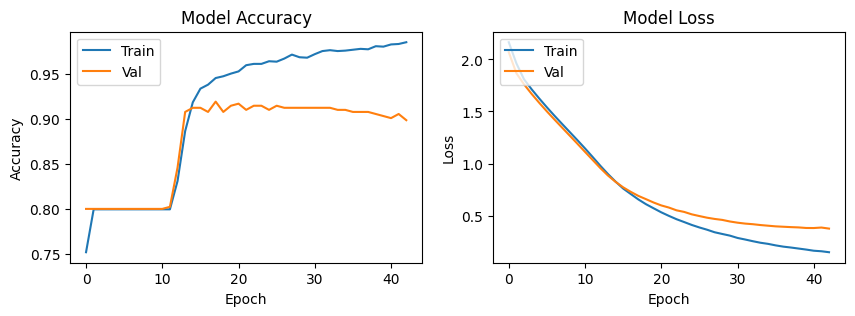

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Val')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Val')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')

plt.show()

In [ ]:
model.save('content_CNN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predictions = model.predict(x_test)

14/14 [==============================] - 0s 3ms/step


In [ ]:
y_pred = predictions >= 0.5

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Macro-Average Precision: {macro_precision}")
print(f"Macro-Average Recall: {macro_recall}")
print(f"Macro-Average F1 Score: {macro_f1}")

Macro-Average Precision: 0.8418254871284312
Macro-Average Recall: 0.8175287356321839
Macro-Average F1 Score: 0.8287753285870756


In [ ]:
from sklearn.metrics import classification_report

labels = ["Negative", "Positive"]
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       348
           1       0.76      0.69      0.72        87

    accuracy                           0.89       435
   macro avg       0.84      0.82      0.83       435
weighted avg       0.89      0.89      0.89       435



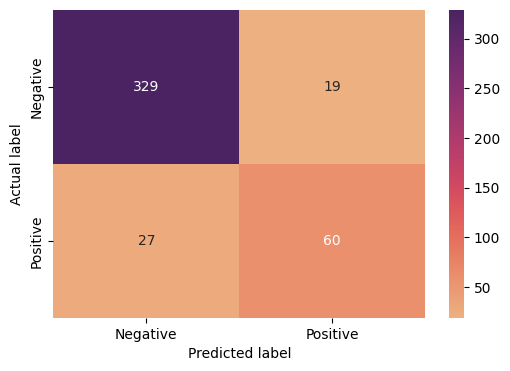

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='flare', fmt='d')
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.show()

# **CNN-LSTM**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Dropout, Activation, MaxPooling1D, Flatten, Embedding
from tensorflow.keras import optimizers, regularizers

def build_CNNLSTM(hp):
  model = Sequential()
  model.add(Embedding(input_dim=2500, output_dim=300,
                      weights=[embedding_matrix], input_length=100))

  filter_sizes = hp.Choice('filter size', values=['2', '2,3,4'])
  filter_sizes_list = [int(x) for x in filter_sizes.split(',')]
  dropout_rate = hp.Choice('dropout rate', values=[0.25, 0.5])
  learn_rate = hp.Choice('learning rate', values=[0.001, 0.0001])

  conv_layers = []
  for filter_size in filter_sizes_list:
    conv_layer = Conv1D(filters=200, kernel_size=filter_size,
                        padding='valid', activation='relu', strides=1)
    conv_layers.append(conv_layer)

  for conv_layer in conv_layers:
    model.add(conv_layer)

  model.add(MaxPooling1D())
  model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(64))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizers.Adam(learning_rate=learn_rate), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
from keras_tuner import GridSearch
from kerastuner.engine.hyperparameters import HyperParameters

tuner = GridSearch(
    build_CNNLSTM,
    objective='val_accuracy',
    directory='content_CNNLSTM',
    project_name='content'
)

tuner.search(x_train, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(x_val,y_val), callbacks=[early_stopping])
tuner.results_summary()

Trial 8 Complete [00h 00m 37s]
val_accuracy: 0.9264367818832397

Best val_accuracy So Far: 0.931034505367279
Total elapsed time: 00h 03m 37s
Results summary
Results in content_CNNLSTM/content
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0003 summary
Hyperparameters:
filter size: 2
dropout rate: 0.5
learning rate: 0.0001
Score: 0.931034505367279

Trial 0001 summary
Hyperparameters:
filter size: 2
dropout rate: 0.25
learning rate: 0.0001
Score: 0.928735613822937

Trial 0002 summary
Hyperparameters:
filter size: 2
dropout rate: 0.5
learning rate: 0.001
Score: 0.9264367818832397

Trial 0007 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.5
learning rate: 0.0001
Score: 0.9264367818832397

Trial 0005 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.25
learning rate: 0.0001
Score: 0.9218390583992004

Trial 0004 summary
Hyperparameters:
filter size: 2,3,4
dropout rate: 0.25
learning rate: 0.001
Score: 0.9195402264595032

Trial 0000 summar

In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp.values

{'filter size': '2', 'dropout rate': 0.5, 'learning rate': 0.0001}

In [ ]:
model = build_CNNLSTM(best_hp)
history = model.fit(x_train, y_train,
                    epochs=50, batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])
model.summary()

Epoch 1/50
32/32 [==============================] - 7s 137ms/step - loss: 2.1516 - accuracy: 0.7438 - val_loss: 2.0377 - val_accuracy: 0.8000
Epoch 2/50
32/32 [==============================] - 4s 114ms/step - loss: 1.9404 - accuracy: 0.7995 - val_loss: 1.8629 - val_accuracy: 0.8000
Epoch 3/50
32/32 [==============================] - 2s 55ms/step - loss: 1.8081 - accuracy: 0.7995 - val_loss: 1.7526 - val_accuracy: 0.8000
Epoch 4/50
32/32 [==============================] - 2s 50ms/step - loss: 1.6999 - accuracy: 0.7995 - val_loss: 1.6468 - val_accuracy: 0.8000
Epoch 5/50
32/32 [==============================] - 2s 52ms/step - loss: 1.5931 - accuracy: 0.7995 - val_loss: 1.5355 - val_accuracy: 0.8000
Epoch 6/50
32/32 [==============================] - 1s 30ms/step - loss: 1.4794 - accuracy: 0.7995 - val_loss: 1.4169 - val_accuracy: 0.8000
Epoch 7/50
32/32 [==============================] - 1s 17ms/step - loss: 1.3559 - accuracy: 0.8005 - val_loss: 1.2974 - val_accuracy: 0.8161
Epoch 8/50


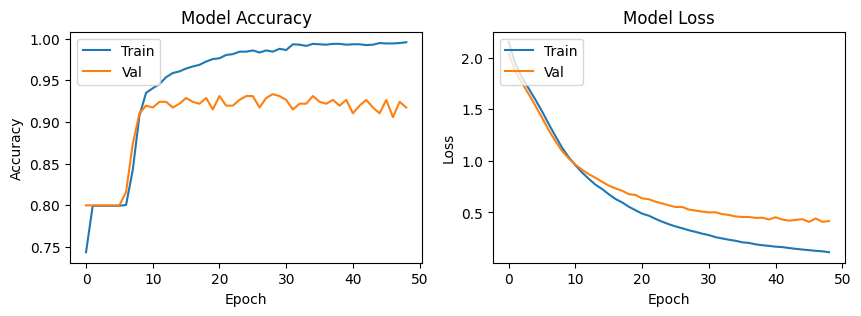

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Val')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Val')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper left')

plt.show()

In [ ]:
model.save('content_CNNLSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
predictions = model.predict(x_test)

14/14 [==============================] - 0s 3ms/step


In [ ]:
y_pred = predictions >= 0.5

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Macro-Average Precision: {macro_precision}")
print(f"Macro-Average Recall: {macro_recall}")
print(f"Macro-Average F1 Score: {macro_f1}")

Macro-Average Precision: 0.8495590954345044
Macro-Average Recall: 0.8247126436781609
Macro-Average F1 Score: 0.8362198795180723


In [ ]:
from sklearn.metrics import classification_report

labels = ["Negative", "Positive"]
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       348
           1       0.77      0.70      0.73        87

    accuracy                           0.90       435
   macro avg       0.85      0.82      0.84       435
weighted avg       0.90      0.90      0.90       435



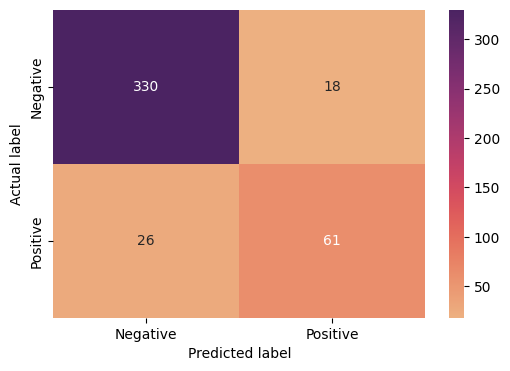

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
ax = sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap='flare', fmt='d')
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.show()